## Reproducibility Workflow (PT/EN)

**PT**: Este notebook utiliza os outputs gerados pelo pipeline em `scripts/`.
Execute primeiro:

```bash
python -m scripts.cli all --year 2024
```

Depois, valide que os arquivos existem em `data/cleaned/`, `outputs/results/`, `outputs/tables/legacy/`, `outputs/figures/legacy/`.

**EN**: This notebook uses outputs produced by the pipeline in `scripts/`.
Run first:

```bash
python -m scripts.cli all --year 2024
```

Then validate that files exist in `data/cleaned/`, `outputs/results/`, `outputs/tables/legacy/`, `outputs/figures/legacy/`.


In [1]:
import pandas as pd

In [2]:
df= pd.read_excel('data/raw/data/raw/Evapo.xlsx', sheet_name='Piracicaba', skiprows=4)

In [13]:
df = df.iloc[0:371].copy()
cols = ['Thornthwaite', 'Thornthwaite-Camargo', 'Camargo',
        'Hargreaves & Samani','Hargreaves & Samani (corrigido)', 'Priestley-Taylor', 'Penman-Monteith', 'Garcia Lopez']
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

ref = df['Penman-Monteith']
media_ref = ref.mean()

In [14]:
def metricas(est, nome):
    diff = est - ref
    rmse = (diff**2).mean() ** 0.5
    mae = diff.abs().mean()
    mbe = diff.mean()
    r2 = ref.corr(est)**2
    d = 1 - ( (diff**2).sum() / ((abs(est - media_ref) + abs(ref - media_ref))**2).sum() )
    return {
        'Método': nome,
        'ETo_anual_mm': round(est.sum(), 1),
        'RMSE': round(rmse, 3),
        'MAE': round(mae, 3),
        'MBE': round(mbe, 3),
        '%_MBE': round(100 * mbe / media_ref, 1),
        'R²': round(r2, 3),
        'd_Willmott': round(d, 3)
    }

resultado = [metricas(ref, 'Penman-Monteith (referência)')]
for c in cols[:-1]:
    resultado.append(metricas(df[c], c))

In [16]:
print(pd.DataFrame(resultado)[['Método','ETo_anual_mm','RMSE','MAE','MBE','%_MBE','R²','d_Willmott']])

                            Método  ETo_anual_mm    RMSE     MAE     MBE  \
0     Penman-Monteith (referência)        1790.7   0.000   0.000   0.000   
1                     Thornthwaite        1185.7   2.248   1.938  -1.653   
2             Thornthwaite-Camargo        6829.1  14.242  13.766  13.766   
3                          Camargo        1164.7   2.262   1.988  -1.710   
4              Hargreaves & Samani        1716.8   0.782   0.653  -0.202   
5  Hargreaves & Samani (corrigido)        1790.7   0.752   0.618  -0.000   
6                 Priestley-Taylor        2316.8   1.958   1.536   1.437   
7                  Penman-Monteith        1790.7   0.000   0.000   0.000   

   %_MBE     R²  d_Willmott  
0    0.0  1.000       1.000  
1  -33.8  0.075       0.464  
2  281.4  0.075       0.147  
3  -35.0  0.072       0.457  
4   -4.1  0.738       0.909  
5   -0.0  0.738       0.918  
6   29.4  0.682       0.749  
7    0.0  1.000       1.000  


In [6]:
manaus= pd.read_excel('data/raw/data/raw/Evapo.xlsx', sheet_name='Manaus', skiprows=4)

In [7]:
manaus = manaus.iloc[0:366].copy()
cols = ['Thornthwaite', 'Thornthwaite-Camargo', 'Camargo',
        'Hargreaves & Samani','Hargreaves & Samani (corrigido)', 'Priestley-Taylor', 'Penman-Monteith']
for c in cols:
    manaus[c] = pd.to_numeric(manaus[c], errors='coerce')

ref = manaus['Penman-Monteith']
media_ref = ref.mean()
def metricas(est, nome):
    diff = est - ref
    rmse = (diff**2).mean() ** 0.5
    mae = diff.abs().mean()
    mbe = diff.mean()
    r2 = ref.corr(est)**2
    d = 1 - ( (diff**2).sum() / ((abs(est - media_ref) + abs(ref - media_ref))**2).sum() )
    return {
        'Método': nome,
        'ETo_anual_mm': round(est.sum(), 1),
        'RMSE': round(rmse, 3),
        'MAE': round(mae, 3),
        'MBE': round(mbe, 3),
        '%_MBE': round(100 * mbe / media_ref, 1),
        'R²': round(r2, 3),
        'd_Willmott': round(d, 3)
    }

resultado = [metricas(ref, 'Penman-Monteith (referência)')]
for c in cols[:-1]:
    resultado.append(metricas(df[c], c))

print(pd.DataFrame(resultado)[['Método','ETo_anual_mm','RMSE','MAE','MBE','%_MBE','R²','d_Willmott']])

                            Método  ETo_anual_mm    RMSE     MAE     MBE  \
0     Penman-Monteith (referência)         928.0   0.000   0.000   0.000   
1                     Thornthwaite        1185.7   1.364   1.196   0.704   
2             Thornthwaite-Camargo        6829.1  16.569  16.123  16.123   
3                          Camargo        1164.7   1.203   1.001   0.647   
4              Hargreaves & Samani        1716.8   2.490   2.195   2.155   
5  Hargreaves & Samani (corrigido)        1790.7   2.688   2.393   2.357   
6                 Priestley-Taylor        2316.8   4.458   3.889   3.794   

   %_MBE     R²  d_Willmott  
0    0.0  1.000       1.000  
1   27.8  0.000       0.382  
2  635.9  0.000       0.058  
3   25.5  0.004       0.406  
4   85.0  0.032       0.295  
5   93.0  0.032       0.280  
6  149.7  0.000       0.169  


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def taylor_diagram(referencia, modelos: dict, titulo='Diagrama de Taylor'):
    """Gera um diagrama de Taylor para comparar modelos com uma série de referência.
    referencia: Serie pandas (referência)
    modelos: dict nome -> Serie pandas
    Retorna (fig, stats_list) onde stats_list contém tuplas (nome, std, corr, crmsd)."""
    ref = referencia.dropna()
    ref_std = ref.std(ddof=0)

    stats = []
    for nome, serie in modelos.items():
        serie = serie.dropna()
        comum = ref.index.intersection(serie.index)
        x = ref.loc[comum]
        y = serie.loc[comum]
        std = y.std(ddof=0)
        corr = x.corr(y)
        crmsd = np.sqrt((((y - y.mean()) - (x - x.mean()))**2).mean())
        stats.append((nome, std, corr, crmsd))

    max_std = max([s[1] for s in stats] + [ref_std]) * 1.25

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, polar=True)

    corr_ticks = np.array([0.2,0.4,0.6,0.7,0.8,0.9,0.95,1.0])
    for r in corr_ticks:
        theta = np.arccos(r)
        ax.plot([theta, theta], [0, max_std], color='#dddddd', lw=0.6)

    std_circles = np.linspace(ref_std*0.5, max_std, 6)
    theta_full = np.linspace(0, np.pi/2, 300)
    for s in std_circles:
        ax.plot(theta_full, np.full_like(theta_full, s), color='#eeeeee', lw=0.5)

    ax.scatter([0],[ref_std], marker='*', color='red', s=140, label='Referência')
    ax.text(0, ref_std*1.02, 'Ref', ha='center', va='bottom', fontsize=9, color='red')

    for nome, std, corr, crmsd in stats:
        theta = np.arccos(corr)
        ax.scatter([theta],[std], s=70, label=nome)
        ax.text(theta, std, nome, fontsize=8, ha='left', va='bottom')

    ax.set_ylim(0, max_std)
    ax.set_thetalim(0, np.pi/2)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.set_xticks(np.arccos(corr_ticks))
    ax.set_xticklabels([f'{r:.2f}' for r in corr_ticks])
    ax.set_ylabel('Desvio Padrão')
    ax.set_title(titulo)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35,1.10), fontsize=8)
    return fig, stats

print('Função taylor_diagram carregada.')

Função taylor_diagram carregada.


                            Método       Std  Correlação     CRMSD
0                     Thornthwaite  0.973798    0.274381  1.523528
1                          Camargo  0.826129    0.267789  1.479994
2  Hargreaves & Samani (corrigido)  1.239986    0.859025  0.752329
3                 Priestley-Taylor  2.252854    0.826009  1.328941


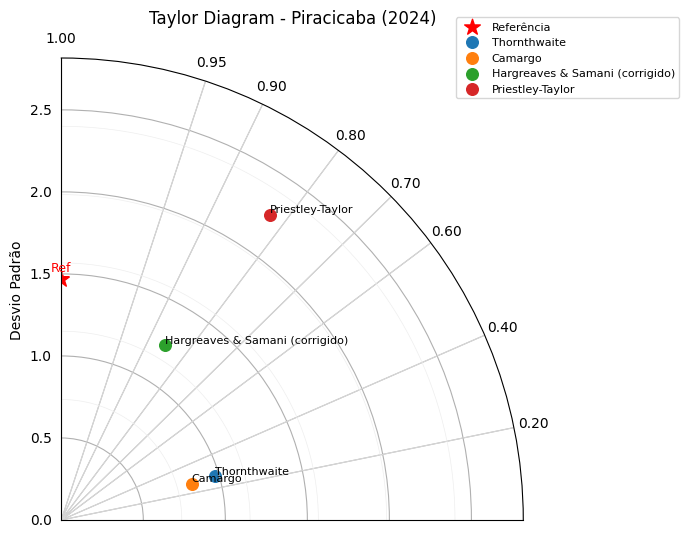

In [ ]:
# Diagrama de Taylor - Piracicaba
ref_p = df['Penman-Monteith']
model_cols_p = ['Thornthwaite', 'Thornthwaite-Camargo', 'Camargo','Hargreaves & Samani (corrigido)',
                'Priestley-Taylor']
modelos_p = {c: df[c] for c in model_cols_p}
fig_p, stats_p = taylor_diagram(ref_p, modelos_p, 'Taylor Diagram - Piracicaba (2024)')
import pandas as pd
print(pd.DataFrame(stats_p, columns=['Método','Std','Correlação','CRMSD']))
plt.show()

                            Método        Std  Correlação      CRMSD
0                     Thornthwaite   0.458225    0.608418  20.573868
1             Thornthwaite-Camargo   0.050805    0.930264  20.802191
2                          Camargo   0.758768    0.192901  20.716461
3              Hargreaves & Samani   0.997121    0.568212  20.299459
4  Hargreaves & Samani (corrigido)  23.288205    0.568212  20.621685
5                 Priestley-Taylor   9.129185    0.584244  17.193984


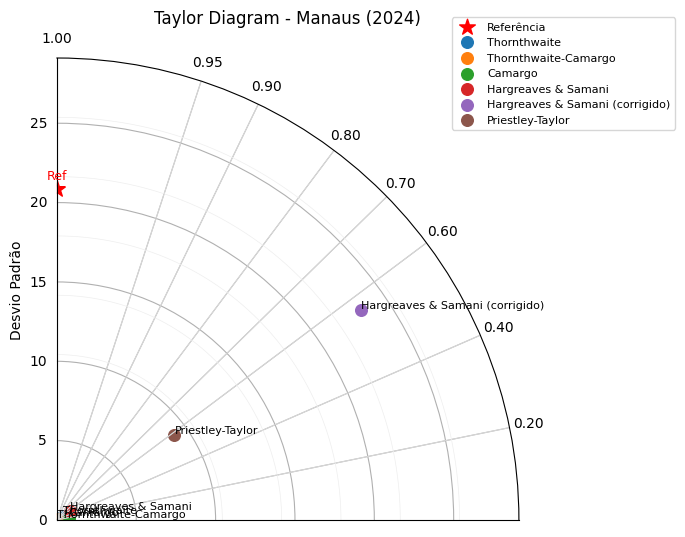

In [40]:
# Diagrama de Taylor - Manaus
ref_m = manaus['Penman-Monteith']
model_cols_m = ['Thornthwaite', 'Thornthwaite-Camargo', 'Camargo',
                'Hargreaves & Samani','Hargreaves & Samani (corrigido)',
                'Priestley-Taylor']
modelos_m = {c: manaus[c] for c in model_cols_m}
fig_m, stats_m = taylor_diagram(ref_m, modelos_m, 'Taylor Diagram - Manaus (2024)')
print(pd.DataFrame(stats_m, columns=['Método','Std','Correlação','CRMSD']))
plt.show()